#1 - Speech Synthesis Introduction

A speech synthesis system takes text as input and generates the corresponding speech signal in the output. Text-to-Speech (TTS) is another name used to refer to such systems.

In this tutorial, we will understand how to implement the following Text-to-Speech system using SpeechBrain:

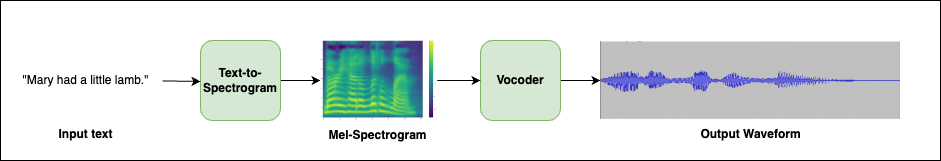

The TTS system in the figure above consists of two components. The first component takes some text as input and produces a Mel spectrogram, a time-frequency representation of speech signals. The second component is a vocoder which converts the Mel spectrogram into the final waveform.

Several models have been proposed in the literature to solve this task. Popular models for the first component are [Tacotron2](https://arxiv.org/abs/1712.05884) and [FastSpeech2](https://arxiv.org/abs/2006.04558). For the vocoder, one popular model is [HiFiGAN](https://arxiv.org/abs/2010.05646).

Tacotron2 and HiFiGAN models are available with SpeechBrain. Here, we will focus on training Tacotron2 to convert input text into output Mel spectrograms. We will use a pretrained HiFiGAN model as a vocoder to generate audio samples.

##1.1 - General Speech Synthesis Pipeline

The system we will study takes text as input and produces a Mel spectrogram as the intermediate feature, which gets converted into the corresponding final audio signal. It is just one way to implement the system. We can follow different paths when building a TTS system. For example:
1. Using phoneme sequences as input instead of a text sequence
2. Providing additional feature information to the system, such as duration, pitch, energy information
3. Using different architectures

This is a general speech synthesis pipeline:

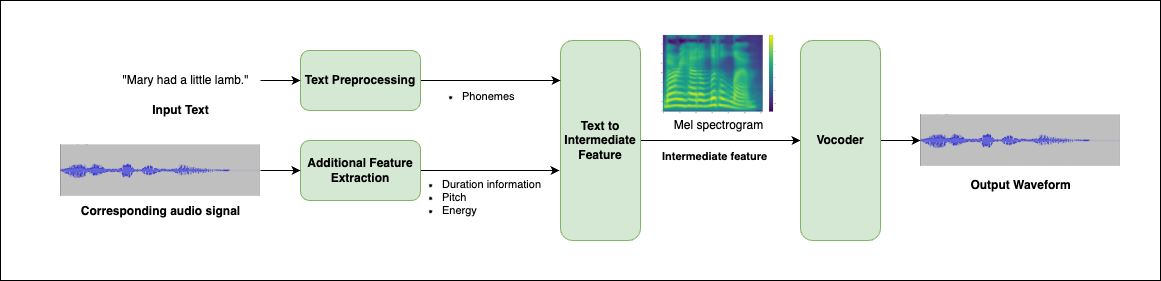

**Note:** There are TTS systems that generate speech based on given input text without using any intermediate features (Mel spectrogram in the above system). Using a two-component system allows us to divide the complex problem of TTS into two components that we can train separately.

#2 - Tacotron2

We can think of Tacotron2 as a recurrent sequence-to-sequence network. The input is a sequence of characters, and the output is a sequence of frames in the Mel spectrogram. The network consists of an encoder and a decoder with attention. We have seen this kind of architecture during the main lectures before.

##2.1 - Tacotron2 Network:

This is a high-level view of the Tacotron2 network:

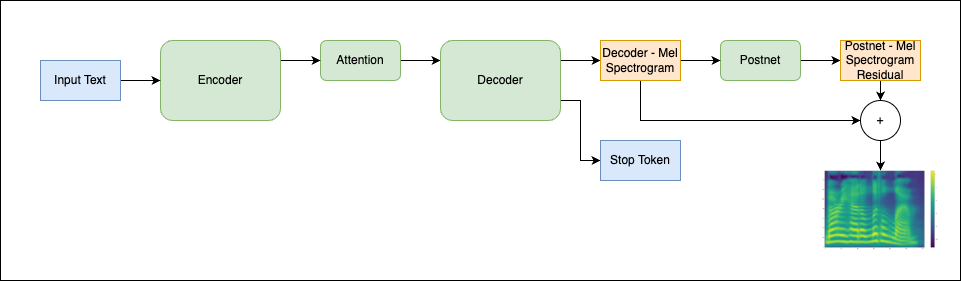

The encoder converts a character sequence into a hidden feature representation (learned fixed-size embeddings).

The encoder output is provided as input to an attention network that summarizes the entire encoded sequence as a fixed-length context vector for each decoding step.

The decoder is an autoregressive RNN. It uses the encoded input sequence to predict the Mel spectrogram one frame at a time. Along with predicting the Mel spectrogram, the decoder also predicts a "stop token" to indicate the whether the output sequence generation is complete. It is helpful during inference as the model can dynamically stop producing the output when a "stop token" is generated.

The Mel spectrogram generated by the decoder is passed through a post-net which predicts a residual to add to the decoded Mel spectrogram to improve the overall reconstruction.

##2.2 - Tacotron2 Training:

The objective function for the Tacotron2 implementation in SpeechBrain consists of the following:
1. Mean Squared Error (MSE) for comparing the predicted and ground truth spectrograms. MSE is computed for the mel spectrogram generated before and after the post-net and summed.
2. Binary Cross Entropy (BCE) for the "stop token" prediction.
3. Guided Attention Loss to force the attention matrices to be near-diagonal. It is helpful for sequence-to-sequence models like Tacotron2, where the output sequence is expected to be closely correlated with the input sequence.

Another thing to note about training is that Tacotron2 uses teacher forcing for the decoder - using the correct values from the ground truth targets instead of predicted values from previous steps. At inference time, the target values are unknown. Hence, predictions from previous time steps are used.

#3 - Tacotron2 with SpeechBrain

In the following sections, we will see how to use SpeechBrain to
1. Train a Tacotron2 mode from scratch,
2. Fine-tune a Tacotron2 model
3. Use a Tacotron2 model trained on the single-speaker LJSpeech dataset in inference mode

##3.1 - Install required packages:

In [ ]:
%%capture
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!sed -i 's/scipy>=1.4.1,<1.13.0/scipy>=1.4.1/' requirements.txt # Temporary Fix (to solve numpy-scipy incompatibility)
!pip install -r requirements.txt
!pip install .
%cd ..

Cloning into 'speechbrain'...
remote: Enumerating objects: 87522, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 87522 (delta 220), reused 108 (delta 106), pack-reused 87232 (from 3)
Receiving objects: 100% (87522/87522), 101.02 MiB | 11.19 MiB/s, done.
Resolving deltas: 100% (58622/58622), done.
/content/speechbrain
Ignoring SoundFile: markers 'sys_platform == "win32"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 k

##3.2 - Prepare the data
Let's download the dataset using the following code cell:

In [ ]:
# Downloads dataset
!pip install --upgrade --no-cache-dir gdown
!gdown 1T4iijQ1hhSw2wATZyJoxsTBACBmYgvBP

Downloading...
From (original): https://drive.google.com/uc?id=1T4iijQ1hhSw2wATZyJoxsTBACBmYgvBP
From (redirected): https://drive.google.com/uc?id=1T4iijQ1hhSw2wATZyJoxsTBACBmYgvBP&confirm=t&uuid=af91ac24-9f7e-49a7-8519-8e283ec397ae
To: /content/libritts_spk_8297.tar.gz
100% 55.8M/55.8M [00:01<00:00, 39.8MB/s]


**Warning:** If you cannot download the data due to an access denied error. Please, download the data from [here](https://drive.google.com/file/d/1-4niAlaEfE53Hq-AJ6c9K--WML4Ql1LC/view?usp=share_link) and upload them manually on Google Colab (Files, upload).

We can extract the dataset using the following code cell:

In [ ]:
# Extract dataset
!tar -xvf libritts_spk_8297.tar.gz

libritts_spk_8297/
libritts_spk_8297/train.json
libritts_spk_8297/test/
libritts_spk_8297/test/8297_275154_000022_000014.original.txt
libritts_spk_8297/test/8297_275154_000035_000002.normalized.txt
libritts_spk_8297/test/8297_275154_000022_000007.normalized.txt
libritts_spk_8297/test/8297_275154_000024_000004.original.txt
libritts_spk_8297/test/8297_275154_000034_000000.original.txt
libritts_spk_8297/test/8297_275154_000006_000005.original.txt
libritts_spk_8297/test/8297_275154_000021_000000.normalized.txt
libritts_spk_8297/test/8297_275154_000022_000007.original.txt
libritts_spk_8297/test/8297_275154_000004_000001.normalized.txt
libritts_spk_8297/test/8297_275154_000024_000009.original.txt
libritts_spk_8297/test/8297_275154_000024_000009.normalized.txt
libritts_spk_8297/test/8297_275154_000022_000013.normalized.txt
libritts_spk_8297/test/8297_275154_000004_000002.original.txt
libritts_spk_8297/test/8297_275154_000019_000003.normalized.txt
libritts_spk_8297/test/8297_275154_000011_0000

The dataset used for this tutorial is based on the [LibriTTS](https://www.openslr.org/60/) dataset. LibriTTS is a multi-speaker English dataset with approximately 585 hours of read English speech at 24kHz sampling rate. It has segments of different sizes. We will use the data for a single speaker (segment: dev-clean, speaker ID: 8297). There are 265 utterances with the total duration of approximately 24 minutes. The utterances are divided into three splits: train (215 utterances), validation (25 utterances), and test (25 utterances). Each split has its own directory and for every utterance, it has the following files:
1. ```{utt_id}.wav```: Audio signal
2. ```{utt_id}.original.txt```: Original text
3. ```{utt_id}.normalized.txt```: Normalized text. We will use the normalized text as matching between normalized text and audio was carried out when creating the LibriTTS dataset.

```utt_id``` is a unique identifier for an utterance.

During data preparation, we create data manifest files. These files contain information about the input text sequences and the location of corresponding target audio data. We will use three files in JSON format - ```train.json```, ```valid.json```, and ```test.json``` - one for each of the train, validation, and test splits. They are available in the compressed dataset we will download.

This is an example of a JSON manifest file:
```
{
  "8297_275154_000015_000000": {
    "label": "Randal admitted it.",
    "wav": "/content/libritts_spk_8297/train/8297_275154_000015_000000.wav"
  },
  "8297_275155_000011_000001": {
    "label": "\"There is my news,\" he said.",
    "wav": "/content/libritts_spk_8297/train/8297_275155_000011_000001.wav"
  },
  "8297_275155_000034_000000": {
    "label": "The very question which Randal had promised to ask in his brother's interests!",
    "wav": "/content/libritts_spk_8297/train/8297_275155_000034_000000.wav"
  }
}
```

The data should have a hierarchical structure. Each entry should represent an utterance from the dataset - the key is a unique identifier for the utterance, and the value represents all the necessary information about it. Here, we need the input text (key ```label```) and the path of the target utterance (key ```wav```). Please note that the names of the keys used for representing utterance information are significant and used later in the experiment script (e.g., ```train.py```).

We will verify if our data is correct before starting the training procedure. Let's load an example and check the input (text) output (audio file) pair. We will use the following example from the provided ```train.json``` file. We will also verify the sample rate of the audio files to check if we need to resample the data before using it in the experiment. We will use a sample rate of 22050 Hz for the experiment.
```
"8297_275154_000015_000000": {
    "label": "Randal admitted it.",
    "wav": "/content/libritts_spk_8297/train/8297_275154_000015_000000.wav"
  }
```

In [ ]:
# Loads an audio
import json
import torchaudio
from IPython.display import Audio

# Note: Please change the file path as required
WAV_FILE_PATH = "/content/libritts_spk_8297/train/8297_275154_000015_000000.wav"

audio_info = torchaudio.info(WAV_FILE_PATH)
print("Sample rate: ", audio_info.sample_rate)
Audio(WAV_FILE_PATH)

Sample rate:  24000


Now, we go to the next steps.

##3.3 - Train Tacotron2 from scratch

Similar to other SpeechBrain recipes, we will need a hyperparameter file (```tacotron2_hparams.yaml```) and a training script (```tacotron2_train.py```). However, every recipe is different, and now we will go through a few things that are specific to this recipe.

Since the model will accept text sequences as input and predict corresponding Mel spectrograms, we should provide the model with the input-output pairs of text and Mel spectrograms. In our dataset, we have text-audio signal pairs. We need to compute the Mel spectrogram for the audio signals.

In the hyperparameters file below, we specify some audio parameters to use for Mel spectrogram computation:
```
################################
# Audio Parameters             #
################################
sample_rate: 22050
hop_length: 256
win_length: 1024
n_mel_channels: 80
n_fft: 1024
mel_fmin: 0.0
mel_fmax: 8000.0
mel_normalized: False
power: 1
norm: "slaney"
mel_scale: "slaney"
dynamic_range_compression: True
```

The function we will use to calculate Mel spectrograms is here:
```
mel_spectogram: !name:speechbrain.lobes.models.Tacotron2.mel_spectogram
  sample_rate: !ref <sample_rate>
  hop_length: !ref <hop_length>
  win_length: !ref <win_length>
  n_fft: !ref <n_fft>
  n_mels: !ref <n_mel_channels>
  f_min: !ref <mel_fmin>
  f_max: !ref <mel_fmax>
  power: !ref <power>
  normalized: !ref <mel_normalized>
  norm: !ref <norm>
  mel_scale: !ref <mel_scale>
  compression: !ref <dynamic_range_compression>
```

Alright! We have the input text sequences and a way to get the output Mel spectrograms. Are we missing anything? Yes. For a given input text sequence, **Tacotron2 predicts a Mel spectrogram AND a "stop token"** to indicate when the output sequence is complete. We need to provide the model target values for predicting stop tokens. The model should output **0** for the stop token until the output Mel spectrogram generation is complete and output **1** afterward.

We collect, combine, and arrange all this information when creating data batches for training, validation, and testing. Another thing to note here is we use a custom collate function to have more flexibility. It is available here:
```
################################
# Dataloader options           #
################################
train_dataloader_opts:
  batch_size: !ref <batch_size>
  drop_last: False  #True #False
  num_workers: 2
  collate_fn: !new:speechbrain.lobes.models.Tacotron2.TextMelCollate
```

Examine the collate function. Were you able to identify all the input-output components we discussed so far? The collate function returns input text sequences, target Mel spectrograms, target stop token values, and other things that provide more information about the batch. Some of them are for logging purposes.

Here are some other hyperparameters to note for this experiment:

We can set the number of epochs using this:
```
epochs: 50
```

For the batch size, we use:
```
batch_size: 16 #minimum 2
```

The following is for setting the initial learning rate:
```
learning_rate: 0.001
```
We say initial learning rate because the recipe uses an interval scheduler for learning rate annealing. It is a simple scheduler implementation. It changes the learning rate to specific values after a predefined number of steps. We are performing a small experiment, so it is unlikely that we will reach the number of steps the interval scheduler needs to change the learning rate. You can fine it here:
```
# annealing_function
lr_annealing: !new:speechbrain.nnet.schedulers.IntervalScheduler
  intervals:
    - steps: 6000
      lr: 0.0005
    - steps: 8000
      lr: 0.0003
    - steps: 10000
      lr: 0.0001
```

The Tacotron2 model parameters are in this section:
```
################################
# Model Parameters and model   #
################################
```

Tacotron2 has a ```Loss``` class defined to compute the loss values as discussed before. It is here:
```
criterion: !new:speechbrain.lobes.models.Tacotron2.Loss
```

You should be familiar with the remaining parts of the hyperparameter file. We will use the following cell to create the complete hyperparameters file.

In [ ]:
%%file tacotron2_hparams.yaml

############################################################################
# Model: Tacotron2
# Tokens: Raw characters (English text)
# ############################################################################

###################################
# Experiment Parameters and setup #
###################################
seed: 1234
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref /content/results/tacotron2/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
epochs: 50
keep_checkpoint_interval: 50

###################################
# Progress Samples                #
###################################
# Progress samples are used to monitor the progress
# of an ongoing training session by outputting samples
# of spectrograms, alignments, etc at regular intervals

# Whether to enable progress samples
progress_samples: True

# The path where the samples will be stored
progress_sample_path: !ref <output_folder>/samples
# The interval, in epochs. For instance, if it is set to 5,
# progress samples will be output every 5 epochs
progress_samples_interval: 1
# The sample size for raw batch samples saved in batch.pth
# (useful mostly for model debugging)
progress_batch_sample_size: 3

#################################
# Data files and pre-processing #
#################################
data_folder: !PLACEHOLDER # e.g, /localscratch/ljspeech

train_json: !ref <data_folder>/train.json
valid_json: !ref <data_folder>/valid.json
test_json: !ref <data_folder>/test.json

splits: ["train", "valid", "test"]
split_ratio: [80, 10, 10]

skip_prep: False

# Use the original preprocessing from nvidia
# The cleaners to be used (applicable to nvidia only)
text_cleaners: ['english_cleaners']

################################
# Audio Parameters             #
################################
sample_rate: 22050
hop_length: 256
win_length: 1024
n_mel_channels: 80
n_fft: 1024
mel_fmin: 0.0
mel_fmax: 8000.0
mel_normalized: False
power: 1
norm: "slaney"
mel_scale: "slaney"
dynamic_range_compression: True

################################
# Optimization Hyperparameters #
################################
learning_rate: 0.001
weight_decay: 0.000006
batch_size: 16 #minimum 2
mask_padding: True
guided_attention_sigma: 0.2
guided_attention_weight: 50.0
guided_attention_weight_half_life: 10.
guided_attention_hard_stop: 50
gate_loss_weight: 1.0

################################
# Dataloader options           #
################################
train_dataloader_opts:
  batch_size: !ref <batch_size>
  drop_last: False  #True #False
  num_workers: 2
  collate_fn: !new:speechbrain.lobes.models.Tacotron2.TextMelCollate

valid_dataloader_opts:
  batch_size: !ref <batch_size>
  num_workers: 2
  collate_fn: !new:speechbrain.lobes.models.Tacotron2.TextMelCollate

test_dataloader_opts:
  batch_size: !ref <batch_size>
  num_workers: 2
  collate_fn: !new:speechbrain.lobes.models.Tacotron2.TextMelCollate

################################
# Model Parameters and model   #
################################
n_symbols: 148 # fixed depending on symbols in textToSequence
symbols_embedding_dim: 512

# Encoder parameters
encoder_kernel_size: 5
encoder_n_convolutions: 3
encoder_embedding_dim: 512

# Decoder parameters
# The number of frames in the target per encoder step
n_frames_per_step: 1
decoder_rnn_dim: 1024
prenet_dim: 256
max_decoder_steps: 1000
gate_threshold: 0.5
p_attention_dropout: 0.1
p_decoder_dropout: 0.1
decoder_no_early_stopping: False

# Attention parameters
attention_rnn_dim: 1024
attention_dim: 128

# Location Layer parameters
attention_location_n_filters: 32
attention_location_kernel_size: 31

# Mel-post processing network parameters
postnet_embedding_dim: 512
postnet_kernel_size: 5
postnet_n_convolutions: 5

mel_spectogram: !name:speechbrain.lobes.models.Tacotron2.mel_spectogram
  sample_rate: !ref <sample_rate>
  hop_length: !ref <hop_length>
  win_length: !ref <win_length>
  n_fft: !ref <n_fft>
  n_mels: !ref <n_mel_channels>
  f_min: !ref <mel_fmin>
  f_max: !ref <mel_fmax>
  power: !ref <power>
  normalized: !ref <mel_normalized>
  norm: !ref <norm>
  mel_scale: !ref <mel_scale>
  compression: !ref <dynamic_range_compression>

# model
model: !new:speechbrain.lobes.models.Tacotron2.Tacotron2
  mask_padding: !ref <mask_padding>
  n_mel_channels: !ref <n_mel_channels>
  # symbols
  n_symbols: !ref <n_symbols>
  symbols_embedding_dim: !ref <symbols_embedding_dim>
  # encoder
  encoder_kernel_size: !ref <encoder_kernel_size>
  encoder_n_convolutions: !ref <encoder_n_convolutions>
  encoder_embedding_dim: !ref <encoder_embedding_dim>
  # attention
  attention_rnn_dim: !ref <attention_rnn_dim>
  attention_dim: !ref <attention_dim>
  # attention location
  attention_location_n_filters: !ref <attention_location_n_filters>
  attention_location_kernel_size: !ref <attention_location_kernel_size>
  # decoder
  n_frames_per_step: !ref <n_frames_per_step>
  decoder_rnn_dim: !ref <decoder_rnn_dim>
  prenet_dim: !ref <prenet_dim>
  max_decoder_steps: !ref <max_decoder_steps>
  gate_threshold: !ref <gate_threshold>
  p_attention_dropout: !ref <p_attention_dropout>
  p_decoder_dropout: !ref <p_decoder_dropout>
  # postnet
  postnet_embedding_dim: !ref <postnet_embedding_dim>
  postnet_kernel_size: !ref <postnet_kernel_size>
  postnet_n_convolutions: !ref <postnet_n_convolutions>
  decoder_no_early_stopping: !ref <decoder_no_early_stopping>

guided_attention_scheduler: !new:speechbrain.nnet.schedulers.StepScheduler
  initial_value: !ref <guided_attention_weight>
  half_life: !ref <guided_attention_weight_half_life>

criterion: !new:speechbrain.lobes.models.Tacotron2.Loss
  gate_loss_weight: !ref <gate_loss_weight>
  guided_attention_weight: !ref <guided_attention_weight>
  guided_attention_sigma: !ref <guided_attention_sigma>
  guided_attention_scheduler: !ref <guided_attention_scheduler>
  guided_attention_hard_stop: !ref <guided_attention_hard_stop>

modules:
  model: !ref <model>

# optimizer
opt_class: !name:torch.optim.Adam
  lr: !ref <learning_rate>
  weight_decay: !ref <weight_decay>

# epoch object
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
  limit: !ref <epochs>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
  save_file: !ref <train_log>

# annealing_function
lr_annealing: !new:speechbrain.nnet.schedulers.IntervalScheduler
  intervals:
    - steps: 6000
      lr: 0.0005
    - steps: 8000
      lr: 0.0003
    - steps: 10000
      lr: 0.0001

# checkpointer
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
  checkpoints_dir: !ref <save_folder>
  recoverables:
    model: !ref <model>
    counter: !ref <epoch_counter>
    scheduler: !ref <lr_annealing>

progress_sample_logger: !new:speechbrain.utils.train_logger.ProgressSampleLogger
  output_path: !ref <progress_sample_path>
  batch_sample_size: !ref <progress_batch_sample_size>
  formats:
    raw_batch: raw

Writing tacotron2_hparams.yaml


We will use the ```tacotron2_train.py``` file to define our training recipe. Let's look at the starting point of the recipe, ```if __name__ == "__main__":```. It gives us a high-level view of the different steps in the recipe. The steps are similar to other recipes we have seen so far. They are as follows:

1. Loading the hyperparameters file with command-line overrides
2. Initializing the distributed data-parallel (required for multi-GPU setup, not needed for the tutorial)
3. Creating the experiment directory
4. Preparing the dataset objects for training, validation, and testing
5. Initializing the brain class
6. Loading pretrained models if required
7. Training the model
8. Testing the model

Now we will focus on different parts of the file used to compose this TTS recipe.

###**Data-IO Pipeline**

The following function is for creating the datasets objects.

```python
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined
    functions. The 'train.json', 'valid.json', and 'test.json' manifest
    files are expected to be available before this function is executed.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the hyperparameters file, and it includes
        all the hyperparameters needed for dataset construction and loading

    Returns
    -------
    datasets : dict
        Contains keys according to the dataset splits specified in the
        hyperparameters file (e.g., "train"/"valid"/"test") that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "label")
    @sb.utils.data_pipeline.provides("mel_text_pair")
    def audio_pipeline(wav, label):

        # Encode the input text
        text_seq = torch.IntTensor(
            text_to_sequence(label, hparams["text_cleaners"])
        )

        # Compute the mel spectrogram
        sig, fs = torchaudio.load(wav)
        sig = torchaudio.functional.resample(sig, fs, hparams["sample_rate"]).squeeze()
        mel = hparams["mel_spectogram"](audio=sig)

        # Get the length of the text sequence.
        # The collate function will arrange the batch in the decreasing order of
        # the input sequence length and use this to return the lengths of
        # samples in the batch
        len_text = len(text_seq)

        return text_seq, mel, len_text

    datasets = {}
    data_info = {
        "train": hparams["train_json"],
        "valid": hparams["valid_json"],
        "test": hparams["test_json"],
    }
    for dataset in hparams["splits"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline],
            output_keys=["mel_text_pair", "wav", "label"],
        )

    return datasets
```

A single pipeline function, ```audio_pipeline```, is used for all the processing. Here is some information about the pipeline:
1. **Input:** It takes the the audio signal path (```wav```) and the input text (```label```) in input. Notice that the keys (```wav```, ```label```) used here are the same as the ones we defined in our data manifest files (```train.json```, ```valid.json```, ```test.json```).

2. **Processing:** It encodes the input text as a text sequence (```text_seq```), loads the audio signal and computes the Mel spectrogram (```mel```), and computes the length of the text sequence (```len_text```).
3.**Output:** The output key, ```mel_text_pair```, is used for the tuple being returned ```(text_seq, mel, len_text)```.

Before returning the dataset objects, the ```dataio_prepare``` specifies which keys will be available in the output. These are used in the custom collate function used for Tacotron2. The collate function then returns the batch as the following tuple:

```
(
  text_padded,
  input_lengths,
  mel_padded,
  gate_padded,
  output_lengths,
  len_x,
  labels,
  wavs,
)
```

Where,

```text_padded```: Text sequences (right zero-padded using max input length)

```input_lengths```: Lengths of the input sequences

```mel_padded```: Target Mel spectrograms (right zero-padded using max target length)

```gate_padded```: Target values for stop token prediction (right zero-padded using max target length)

```output_lengths```: Lengths of the target Mel spectrograms

```len_x```: Lengths of the input sequences (This is extra, and we will not use it in the recipe)

```labels```: Input text

```wavs```: Ground truth/target audio signals


Can we use this batch tuple in our brain class now? Not yet. This recipe has a method called ```batch_to_device``` that moves the batch to the target device and creates the effective batch. We will use the effective batch returned from ```batch_to_device``` in the brain class.

```python
def batch_to_device(self, batch):
    """Transfers the batch to the target device

    Arguments
    ---------
    batch: tuple
        the batch to use

    Returns
    -------
    batch: tiuple
        the batch on the correct device
    """
    (
        text_padded,
        input_lengths,
        mel_padded,
        gate_padded,
        output_lengths,
        len_x,
        labels,
        wavs,
    ) = batch
    text_padded = text_padded.to(self.device, non_blocking=True).long()
    input_lengths = input_lengths.to(self.device, non_blocking=True).long()
    max_len = torch.max(input_lengths.data).item()
    mel_padded = mel_padded.to(self.device, non_blocking=True).float()
    gate_padded = gate_padded.to(self.device, non_blocking=True).float()

    output_lengths = output_lengths.to(
        self.device, non_blocking=True
    ).long()
    x = (text_padded, input_lengths, mel_padded, max_len, output_lengths)
    y = (mel_padded, gate_padded)
    return (x, y, labels, wavs)
```

The return value of this function is the batch we will use in this recipe.

###Forward Computations

```compute_forward``` is the method of the Tacotron2Brain class used to compute a forward pass, mapping input to output.

```python
def compute_forward(self, batch, stage):
    """Computes the forward pass

    Arguments
    ---------
    batch: str
        a single batch
    stage: speechbrain.Stage
        the training stage

    Returns
    -------
    the model output
    """
    effective_batch = self.batch_to_device(batch)

    # Get inputs from the effective batch
    inputs, _, _, _ = effective_batch

    # Compute the max input length used for alignments_dim
    # Optional but needed for data-parallel training
    _, input_lengths, _, _, _ = inputs
    max_input_length = input_lengths.max().item()

    # Get predictions for mel spectrograms, stop tokens, and alignments
    (
      mel_outputs,
      mel_outputs_postnet,
      gate_outputs,
      alignments
    ) = self.modules.model(inputs, alignments_dim=max_input_length)

    predictions = (mel_outputs, mel_outputs_postnet, gate_outputs, alignments)

    return predictions
```

The function takes the batch variable and the current stage (```sb.Stage.TRAIN```, ```sb.Stage.VALID```, or ```sb.Stage.TEST```).

We move the batch to the correct device and get the effective batch using ```self.batch_to_device(batch)```.

Then we pass our data through the Tacotron2 model. The forward method of the model expects ```inputs``` and an optional parameter ```alignments_dim```.
* We constructed ```inputs``` in ```batch_to_device``` method. It is the following tuple: ```(text_padded, input_lengths, mel_padded, max_len, output_lengths)```.
* ```alignments_dim``` is the desired dimension of the alignments along the last axis. It is required for data-parallel training.

The model returns predictions for the Mel spectrograms, stop tokens, and alignments as a tuple. This ```predictions``` tuple is the return value of the ```compute_forward``` method.

###Compute Objectives

```compute_objectives``` method of the Tacotron2Brain class is used for computing and returning the loss. This method passes the ```predictions``` and ```effective_batch``` to another method, ```_compute_loss``` for loss computation. We will focus on ```_compute_loss``` here:

```python
def _compute_loss(self, predictions, batch, stage):
    """Computes the value of the loss function and updates stats

    Arguments
    ---------
    predictions: tuple
        model predictions
    targets: tuple
        ground truth data

    Returns
    -------
    loss: torch.Tensor
        the loss value
    """

    # Unpack the batch
    inputs, targets, _, _ = batch
    _, input_lengths, _, _, output_lengths = inputs

    # Compute loss
    loss_stats = self.hparams.criterion(
        predictions, targets, input_lengths, output_lengths, self.last_epoch
    )

    self.last_loss_stats[stage] = scalarize(loss_stats)
    return loss_stats.loss
```

It simply unpacks the batch and passes the required values for loss computation to the ```criterion``` defined in the hyperparameters file. The ```criterion``` computes the three losses (Mel spectrogram loss, stop token loss, attention loss) discussed above and adds them to get the total loss.

###Other Methods of the Tacotron2Brain class

Apart from the methods discussed above, the Tacotron2Brain class has these methods:

```on_fit_start```: Gets called at the beginning of ``fit()``. Does statistics initialization. We instantiate a vocoder (```self.vocoder```) here to save audio samples throughout the training.

```fit_batch```: Fits a single batch and applies annealing.

```_remember_sample```: Remembers samples of spectrograms and the batch for logging purposes.

```_get_spectrogram_sample```: Converts a raw spectrogram to one that can be saved as an image

```on_stage_end```: Gets called at the end of a stage. Manages statistics updates, learning rate annealing, logging, checkpointing

```run_inference_sample```: Produces a sample in inference mode (Tacotron2 + vocoder). It is useful to observe the changes in output audio quality throughout the training.

We will use the following cell to create the complete train file.

In [ ]:
%%file tacotron2_train.py

# -*- coding: utf-8 -*-
"""
 Recipe for training the Tacotron Text-To-Speech model, an end-to-end
 neural text-to-speech (TTS) system

 To run this recipe, do the following:
 # python train.py --device=cuda:0 --max_grad_norm=1.0 --data_folder=/your_folder/LJSpeech-1.1 hparams/train.yaml

 Authors for the original LJSpeech recipe available on SpeechBrain
 * Georges Abous-Rjeili 2021
 * Artem Ploujnikov 2021
 * Yingzhi Wang 2022
"""
import torch
import torchaudio
import speechbrain as sb
from speechbrain.inference.vocoders import HIFIGAN
import sys
import os
import logging
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.text_to_sequence import text_to_sequence
from speechbrain.utils.data_utils import scalarize

logger = logging.getLogger(__name__)


class Tacotron2Brain(sb.Brain):
    """The Brain implementation for Tacotron2"""

    def on_fit_start(self):
        """Gets called at the beginning of ``fit()``, on multiple processes
        if ``distributed_count > 0`` and backend is ddp and initializes statistics"""
        self.hparams.progress_sample_logger.reset()
        self.last_epoch = 0
        self.last_batch = None
        self.last_loss_stats = {}

        self.vocoder = HIFIGAN.from_hparams(
            source="speechbrain/tts-hifigan-libritts-22050Hz",
            savedir="tmpdir_vocoder",
            run_opts={"device": self.device},
        )

        return super().on_fit_start()

    def compute_forward(self, batch, stage):
        """Computes the forward pass

        Arguments
        ---------
        batch: str
            a single batch
        stage: speechbrain.Stage
            the training stage

        Returns
        -------
        the model output
        """
        effective_batch = self.batch_to_device(batch)

        # Get inputs from the effective batch
        inputs, _, _, _ = effective_batch

        # Compute the max input length used for alignments_dim
        # Optional but needed for data-parallel training
        _, input_lengths, _, _, _ = inputs
        max_input_length = input_lengths.max().item()

        # Get predictions for mel spectrograms, stop tokens, and alignments
        (
          mel_outputs,
          mel_outputs_postnet,
          gate_outputs,
          alignments
        ) = self.modules.model(inputs, alignments_dim=max_input_length)

        predictions = (mel_outputs, mel_outputs_postnet, gate_outputs, alignments)

        return predictions

    def fit_batch(self, batch):
        """Fits a single batch and applies annealing

        Arguments
        ---------
        batch: tuple
            a training batch

        Returns
        -------
        loss: torch.Tensor
            detached loss
        """
        result = super().fit_batch(batch)
        self.hparams.lr_annealing(self.optimizer)
        return result

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.
        Arguments
        ---------
        predictions : torch.Tensor
            The model generated spectrograms and other metrics from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        effective_batch = self.batch_to_device(batch)
        # Hold on to the batch for the inference sample. This is needed because
        # the infernece sample is run from on_stage_end only, where
        # batch information is not available
        self.last_batch = effective_batch
        # Hold on to a sample (for logging)
        self._remember_sample(effective_batch, predictions)
        # Compute the loss
        loss = self._compute_loss(predictions, effective_batch, stage)
        return loss

    def _compute_loss(self, predictions, batch, stage):
        """Computes the value of the loss function and updates stats

        Arguments
        ---------
        predictions: tuple
            model predictions
        targets: tuple
            ground truth data

        Returns
        -------
        loss: torch.Tensor
            the loss value
        """

        # Unpack the batch
        inputs, targets, _, _ = batch
        _, input_lengths, _, _, output_lengths = inputs

        # Compute loss
        loss_stats = self.hparams.criterion(
            predictions, targets, input_lengths, output_lengths, self.last_epoch
        )

        self.last_loss_stats[stage] = scalarize(loss_stats)
        return loss_stats.loss

    def _remember_sample(self, batch, predictions):
        """Remembers samples of spectrograms and the batch for logging purposes

        Arguments
        ---------
        batch: tuple
            a training batch
        predictions: tuple
            predictions (raw output of the Tacotron model)
        """
        inputs, targets, labels, wavs = batch
        text_padded, input_lengths, _, max_len, output_lengths = inputs
        mel_target, _ = targets
        mel_out, mel_out_postnet, gate_out, alignments = predictions
        alignments_max = (
            alignments[0]
            .max(dim=-1)
            .values.max(dim=-1)
            .values.unsqueeze(-1)
            .unsqueeze(-1)
        )
        alignments_output = alignments[0].T.flip(dims=(1,)) / alignments_max
        self.hparams.progress_sample_logger.remember(
            target=self._get_spectrogram_sample(mel_target),
            output=self._get_spectrogram_sample(mel_out),
            output_postnet=self._get_spectrogram_sample(mel_out_postnet),
            alignments=alignments_output,
            raw_batch=self.hparams.progress_sample_logger.get_batch_sample(
                {
                    "text_padded": text_padded,
                    "input_lengths": input_lengths,
                    "mel_target": mel_target,
                    "mel_out": mel_out,
                    "mel_out_postnet": mel_out_postnet,
                    "max_len": max_len,
                    "output_lengths": output_lengths,
                    "gate_out": gate_out,
                    "alignments": alignments,
                    "labels": labels,
                    "wavs": wavs,
                }
            ),
        )

    def batch_to_device(self, batch):
        """Transfers the batch to the target device

        Arguments
        ---------
        batch: tuple
            the batch to use

        Returns
        -------
        batch: tiuple
            the batch on the correct device
        """
        (
            text_padded,
            input_lengths,
            mel_padded,
            gate_padded,
            output_lengths,
            len_x,
            labels,
            wavs,
        ) = batch
        text_padded = text_padded.to(self.device, non_blocking=True).long()
        input_lengths = input_lengths.to(self.device, non_blocking=True).long()
        max_len = torch.max(input_lengths.data).item()
        mel_padded = mel_padded.to(self.device, non_blocking=True).float()
        gate_padded = gate_padded.to(self.device, non_blocking=True).float()

        output_lengths = output_lengths.to(
            self.device, non_blocking=True
        ).long()
        x = (text_padded, input_lengths, mel_padded, max_len, output_lengths)
        y = (mel_padded, gate_padded)
        return (x, y, labels, wavs)

    def _get_spectrogram_sample(self, raw):
        """Converts a raw spectrogram to one that can be saved as an image
        sample  = sqrt(exp(raw))

        Arguments
        ---------
        raw: torch.Tensor
            the raw spectrogram (as used in the model)

        Returns
        -------
        sample: torch.Tensor
            the spectrogram, for image saving purposes
        """
        sample = raw[0]
        return torch.sqrt(torch.exp(sample))

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.

        # At the end of validation, we can write
        if stage == sb.Stage.VALID:
            # Update learning rate
            lr = self.optimizer.param_groups[-1]["lr"]
            self.last_epoch = epoch

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(  # 1#2#
                stats_meta={"Epoch": epoch, "lr": lr},
                train_stats=self.last_loss_stats[sb.Stage.TRAIN],
                valid_stats=self.last_loss_stats[sb.Stage.VALID],
            )

            # Save the current checkpoint and delete previous checkpoints.
            epoch_metadata = {
                **{"epoch": epoch},
                **self.last_loss_stats[sb.Stage.VALID],
            }
            self.checkpointer.save_and_keep_only(
                meta=epoch_metadata,
                min_keys=["loss"],
                ckpt_predicate=(
                    lambda ckpt: (
                        ckpt.meta["epoch"]
                        % self.hparams.keep_checkpoint_interval
                        != 0
                    )
                )
                if self.hparams.keep_checkpoint_interval is not None
                else None,
            )
            output_progress_sample = (
                self.hparams.progress_samples
                and epoch % self.hparams.progress_samples_interval == 0
            )
            if output_progress_sample:
                self.run_inference_sample()
                self.hparams.progress_sample_logger.save(epoch)

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=self.last_loss_stats[sb.Stage.TEST],
            )
            if self.hparams.progress_samples:
                self.run_inference_sample()
                self.hparams.progress_sample_logger.save("test")

    def run_inference_sample(self):
        """Produces a sample in inference mode. This can be useful to observe the changes in output quality throughout the training."""
        if self.last_batch is None:
            return

        inf_sample_path = os.path.join(
            self.hparams.progress_sample_path,
            str(self.hparams.epoch_counter.current),
        )

        if not os.path.exists(inf_sample_path):
            os.makedirs(inf_sample_path)


        inputs, _, labels, wavs = self.last_batch
        text_padded, input_lengths, _, _, _ = inputs
        mel_out, _, _ = self.hparams.model.infer(
            text_padded[:1], input_lengths[:1]
        )
        self.hparams.progress_sample_logger.remember(
            inference_mel_out=self._get_spectrogram_sample(mel_out)
        )

        waveform_ss = self.vocoder.decode_batch(mel_out)
        inf_sample_audio = os.path.join(
            self.hparams.progress_sample_path,
            str(self.hparams.epoch_counter.current),
            "inf_output_audio.wav",
        )
        torchaudio.save(
            inf_sample_audio,
            waveform_ss.squeeze(1).cpu(),
            self.hparams.sample_rate,
        )

        inf_sample_text = os.path.join(
            self.hparams.progress_sample_path,
            str(self.hparams.epoch_counter.current),
            "inf_input_text.txt",
        )
        with open(inf_sample_text, "w") as f:
            f.write(labels[0])

        inf_input_audio = os.path.join(
            self.hparams.progress_sample_path,
            str(self.hparams.epoch_counter.current),
            "inf_input_audio.wav",
        )
        torchaudio.save(
            inf_input_audio,
            sb.dataio.dataio.read_audio(wavs[0]).unsqueeze(0),
            self.hparams.sample_rate,
        )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined
    functions. The 'train.json', 'valid.json', and 'test.json' manifest
    files are expected to be available before this function is executed.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the hyperparameters file, and it includes
        all the hyperparameters needed for dataset construction and loading

    Returns
    -------
    datasets : dict
        Contains keys according to the dataset splits specified in the
        hyperparameters file (e.g., "train"/"valid"/"test") that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav", "label")
    @sb.utils.data_pipeline.provides("mel_text_pair")
    def audio_pipeline(wav, label):

        # Encode the input text
        text_seq = torch.IntTensor(
            text_to_sequence(label, hparams["text_cleaners"])
        )

        # Compute the mel spectrogram
        sig, fs = torchaudio.load(wav)
        sig = torchaudio.functional.resample(sig, fs, hparams["sample_rate"]).squeeze()
        mel = hparams["mel_spectogram"](audio=sig)

        # Get the length of the text sequence.
        # The collate function will arrange the batch in the decreasing order of
        # the input sequence length and use this to return the lengths of
        # samples in the batch
        len_text = len(text_seq)

        return text_seq, mel, len_text

    datasets = {}
    data_info = {
        "train": hparams["train_json"],
        "valid": hparams["valid_json"],
        "test": hparams["test_json"],
    }
    for dataset in hparams["splits"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline],
            output_keys=["mel_text_pair", "wav", "label"],
        )

    return datasets


if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If --distributed_launch then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    datasets = dataio_prepare(hparams)

    # Load pretrained model if pretrained_separator is present in the yaml
    if "pretrained_separator" in hparams:
        sb.utils.distributed.run_on_main(hparams["pretrained_separator"].collect_files)
        hparams["pretrained_separator"].load_collected()

    # Brain class initialization
    tacotron2_brain = Tacotron2Brain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    tacotron2_brain.fit(
        tacotron2_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Test
    if "test" in datasets:
        tacotron2_brain.evaluate(
            datasets["test"],
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

Writing tacotron2_train.py


We can use the following cell to run the TTS recipe.

In [ ]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf /content/results/tacotron2/1234

# Run Training
!python tacotron2_train.py tacotron2_hparams.yaml  --data_folder="/content/libritts_spk_8297" --device="cuda:0" --epochs=25 --seed=1234

We ran the experiment for 25 epochs. It took around 20 minutes on Google Colab. During training, we generate and save a sample in inference mode to observe the change in audio quality. For this experiment, the output audio quality should be poor as we are using a small amount of data (approximately 24 minutes) and training it for 25 epochs from scratch.

The SpeechBrain Tacotron2 model available on HuggingFace is trained using the entire LJSpeech dataset. LJSpeech has approximately 24 hours of data for a single speaker. The model is trained for 500 epochs. It takes a few days to train the model depending on the system. The voice generated by the model at inference time correponds to the voice available in the LJSpeech dataset.

**Warning:** The output audio generated from this experiment may contain loud noises. Please try to avoid using earphones when listening to the samples.

##3.4 - Fine-tune Tacotron2 to a different voice

Training a TTS system requires a lot of data, and training even a single-speaker TTS system takes considerable time. Rather than training a new model from scratch for a different voice, we can start from a pre-trained Tacotron2 model and fine-tune it to the desired voice. This gives the model a good starting point and should require less amount of data as well. Note that to make it possible, the architecture of your model must match exactly with the pre-trained one.

One convenient way is to use the ```Pretrainer``` class in the hyperparameters file. If you want to pre-train the Tacotron2 model, you can use the following code:

```
# If you do not want to use the pretrained separator you can simply delete pretrained_separator field
pretrained_separator: !new:speechbrain.utils.parameter_transfer.Pretrainer
  collect_in: !ref <save_folder>
  loadables:
    model: !ref <model>
  paths:
    model: !ref <model_ptfile>
```

Here, ```!ref <model>``` points to the model previously defined in the hyperparameters file, and ```model_ptfile``` is the path where you have stored your pre-trained model. The path of the pre-trained model can be a local path, a web URL, or a huggingface repository. For example, the path for the pretrained Tacotron2 model available on huggingface is this: ```speechbrain/tts-tacotron2-ljspeech/model.ckpt```.

We have already added the following code required for using pre-training in the ```tacotron2_train.py``` file, so you do not have to modify the training file to run it in this tutorial. Please ensure you use it every time you would like to take advantage of pre-training. This should be present before the ```fit``` method of the brain class.

```python
# Load pretrained model if pretrained_separator is present in the yaml
    if "pretrained_separator" in hparams:
        sb.utils.distributed.run_on_main(hparams["pretrained_separator"].collect_files)
        hparams["pretrained_separator"].load_collected(device=run_opts["device"])
```

Another thing to note when fine-tuning Tacotron2 is that the learning rate should be reduced when fine-tuning. Otherwise, we may end up destroying everything we learned before. The pretrained Tacotron2 model had an initial learning rate of ```0.001```, which was eventually reduced to ```0.0001``` with learning rate annealing. A good starting point for this fine-tuning exercise is to use ```0.0001``` as the initial learning rate.

If you run the fine-tune experiment with:
1. The pretrained Tacotron2 model above
2. A reduced learning rate (```0.0001```)
3. Keeping everything else the same,

you should be able to get intelligible output with considerable voice change after 10 epochs. The pre-trained model loaded for this tutorial was trained on the LJSpeech dataset. LJSpeech has data available for only one female speaker. For this tutorial, we selected data for a male speaker so the voice change is easy to notice. Compare the voice you get after fine-tuning in this section with the original LJSpeech voice in the next section.

##3.5 - Inference with Tacotron2

At this point, we can use the trained TTS model. The following is an example of how to use the Tacotron2 and HiFiGAN models available at SpeechBrain's [HuggingFace repository](https://huggingface.co/speechbrain).

In [ ]:
import torchaudio
from speechbrain.inference.TTS import Tacotron2
from speechbrain.inference.vocoders import HIFIGAN

# Intialize TTS (tacotron2) and Vocoder (HiFIGAN)
tacotron2 = Tacotron2.from_hparams(source="speechbrain/tts-tacotron2-ljspeech", savedir="tmpdir_tts")
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-22050Hz", savedir="tmpdir_vocoder")

# Running the TTS
INPUT_TEXT = "Mary had a little lamb"
mel_output, mel_length, alignment = tacotron2.encode_text(INPUT_TEXT)

# Running Vocoder (spectrogram-to-waveform)
waveforms = hifi_gan.decode_batch(mel_output)

# Save the waverform
torchaudio.save("example_TTS.wav", waveforms.squeeze(1), 22050)

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/tts-tacotron2-ljspeech' if not cached


hyperparams.yaml:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--tts-tacotron2-ljspeech/snapshots/d01e530d6d8e1b388c04b882305867addbed4389/hyperparams.yaml' -> '/content/tmpdir_tts/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-tacotron2-ljspeech' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmpdir_tts.
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Fetching from HuggingFace Hub 'speechbrain/tts-tacotron2-ljspeech' if not cached


model.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--tts-tacotron2-ljspeech/snapshots/d01e530d6d8e1b388c04b882305867addbed4389/model.ckpt' -> '/content/tmpdir_tts/model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["model"] = /content/tmpdir_tts/model.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: model
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): model -> /content/tmpdir_tts/model.ckpt
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-libritts-22050Hz' if not cached


hyperparams.yaml:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--tts-hifigan-libritts-22050Hz/snapshots/4188503131602dc234f48d7f22eebea93d788736/hyperparams.yaml' -> '/content/tmpdir_vocoder/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-libritts-22050Hz' if not cached
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmpdir_vocoder.
INFO:speechbrain.utils.fetching:Fetch generator.ckpt: Fetching from HuggingFace Hub 'speechbrain/tts-hifigan-libritts-22050Hz' if not cached


generator.ckpt:   0%|          | 0.00/55.8M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--tts-hifigan-libritts-22050Hz/snapshots/4188503131602dc234f48d7f22eebea93d788736/generator.ckpt' -> '/content/tmpdir_vocoder/generator.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["generator"] = /content/tmpdir_vocoder/generator.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: generator
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): generator -> /content/tmpdir_vocoder/generator.ckpt


We can use the following cell to load and listen to the sample.

In [ ]:
# Note: Please change the file path as required
WAV_FILE_PATH = "example_TTS.wav"
Audio(WAV_FILE_PATH)